In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from utils.dataprep import prepare_data
from utils.radiomics import CNNDataset, pos_neg_aug_datasets, get_pos_data, get_neg_data, get_aug_data, compute_distribution

from torch.utils.data import DataLoader
from utils.radiomics import calc_stats, visualize_batch, FilteredDataLoader

import torch

from utils.train import get_sampler, plot_imbalance, binary_accuracy, get_metrics, epoch_time, train, plot_metrics, train_xgboost_model, bayes_xgboost_model

/projects/renal/02_kidney_classification/01_3DCNN/02_subtypes/utils/dataprep.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1_selected.iloc[:, 1] = df1_selected.iloc[:, 1].map({'Right': 1 , 'Left': 0}) # Right is [1,0], Left is [0,1]
2024-07-05 03:11:11.659638: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-05 03:11:11.663754: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-05 03:11:11.730057: I tensorflow/core/platform/cpu_feature_guard.cc:182] Thi

## Load Test data

In [2]:
data, target = prepare_data()

pos_dataset, aug_pos_dataset, neg_dataset, aug_neg_dataset = pos_neg_aug_datasets(data, target)

Concatenation ...
Number of Patients ready for training: 268
Negative Data:
41

Positive Data:
220


100%|██████████| 220/220 [12:28<00:00,  3.40s/it]

Total original negative samples: 41
Total augmented negative samples: 1107
Total original positive samples: 220
Total augmented positive samples: 1100


In [36]:
# Create DataLoader for original datasets
batch_size = 32

loader_positives = DataLoader(pos_dataset, batch_size=batch_size)
loader_positives_aug = DataLoader(aug_pos_dataset, batch_size=batch_size)  # additional pos data 
loader_negatives = DataLoader(neg_dataset, batch_size=batch_size)
loader_negatives_aug = DataLoader(aug_neg_dataset, batch_size=batch_size)  # additional neg data

pos_data_dict_ , aug_pos_data_dict_, neg_data_dict_, aug_neg_data_dict_ = dict(), dict(), dict(), dict()

pos_data_dict_ = get_pos_data(loader_positives)
aug_pos_data_dict_ = get_aug_data(loader_positives_aug)
neg_data_dict_ = get_neg_data(loader_negatives)
aug_neg_data_dict_ = get_aug_data(loader_negatives_aug)

Processing ccRCC Patients ...:   0%|          | 0/7 [00:00<?, ?it/s]invalid value encountered in scalar divide
32it [00:00, 36.03it/s]
Processing Augmented Patients: 100%|██████████| 35/35 [00:13<00:00,  2.68it/s]


In [38]:
# Splitting positive data into train and validation/test sets
X_train_val_pos, X_test_pos, y_train_val_pos, y_test_pos, id_train_val_pos, id_test_pos = train_test_split(
    pos_data_dict_['img'],
    pos_data_dict_['label'],
    pos_data_dict_['Patient_ID'],
    stratify=pos_data_dict_['label'],
    test_size=0.2,
    random_state=42
)

# Splitting the validation/test positive set into validation and test sets
'''X_val_pos, X_test_pos, y_val_pos, y_test_pos, id_val_pos, id_test_pos = train_test_split(
    X_val_test_pos,
    y_val_test_pos,
    id_val_test_pos,
    stratify=y_val_test_pos,
    test_size=0.50,
    random_state=42
)'''

# Merging positive training data with augmented and negative data
X_train_cnn = X_train_val_pos + neg_data_dict_['img'][40:]  + neg_data_dict_['img'][20:40] # + aug_pos_data_dict_['img'][:872] + aug_neg_data_dict_['img'] 
y_train_cnn = y_train_val_pos + neg_data_dict_['label'][40:] + neg_data_dict_['label'][20:40]# + aug_pos_data_dict_['label'][:872] + aug_neg_data_dict_['label'] 
id_train_cnn = id_train_val_pos + neg_data_dict_['Patient_ID'][40:] + neg_data_dict_['Patient_ID'][20:40]#  + aug_pos_data_dict_['Patient_ID'][:872] + aug_neg_data_dict_['Patient_ID']


# Merging validation and test sets with negative data
X_test_cnn = X_test_pos[:20] + neg_data_dict_['img'][:20] 
y_test_cnn = y_test_pos[:20] + neg_data_dict_['label'][:20] 
id_test_cnn = id_test_pos[:20] + neg_data_dict_['Patient_ID'][:20] 

# Converting to numpy arrays for easy manipulation
np_y_train = np.array(y_train_cnn)
np_y_test = np.array(y_test_cnn)
#np_y_val = np.array(y_val_cnn)

# Print class distributions
print("TRAIN SET: ")
print("ccRCC: ", len(np_y_train[np_y_train == 1]))
print("Non ccRCC: ", len(np_y_train[np_y_train == 0]))

'''print("VAL SET: ")
print("ccRCC: ", len(np_y_val[np_y_val == 1]))
print("Non ccRCC: ", len(np_y_val[np_y_val == 0]))'''

print("TEST SET: ")
print("ccRCC: ", len(np_y_test[np_y_test == 1]))
print("Non ccRCC: ", len(np_y_test[np_y_test == 0]))


TRAIN SET: 
ccRCC:  176
Non ccRCC:  21
TEST SET: 
ccRCC:  20
Non ccRCC:  20


In [51]:
pos_data_dict = pos_data_dict_
neg_data_dict = neg_data_dict_
aug_pos_data_dict = aug_pos_data_dict_
aug_neg_data_dict = aug_neg_data_dict_

pos_features = []
neg_features = []
aug_pos_features = []
aug_neg_features = []
for neg in neg_data_dict['radiomics']:
    neg_features.append(neg[:3])

for pos in pos_data_dict['radiomics']:
    pos_features.append(pos[:3])
  
for aug in aug_pos_data_dict['radiomics']:
    aug_pos_features.append(aug[:3])

for aug in aug_neg_data_dict['radiomics']:
    aug_neg_features.append(aug[:3])

X_train_pos, X_val_test_pos, y_train_pos, y_val_test_pos, id_train_pos, id_val_test_pos = train_test_split(
                                                    np.array(pos_features),
                                                    np.array(pos_data_dict['label']),
                                                    pos_data_dict_['Patient_ID'],
                                                    stratify=pos_data_dict['label'],
                                                    test_size=0.2, random_state=42)

X_train_xgb = np.concatenate((X_train_pos, np.array(aug_pos_features[:932]), ), axis=0)
y_train_xgb = np.concatenate((y_train_pos, np.array(aug_pos_data_dict['label'][:932])), axis=0)

X_train_xgb = np.concatenate((X_train_xgb, np.array(aug_neg_features), ), axis=0)
y_train_xgb = np.concatenate((y_train_xgb, np.array(aug_neg_data_dict['label'])), axis=0)

X_train_xgb = np.concatenate((X_train_xgb, np.array(neg_features[40:])), axis=0)
y_train_xgb = np.concatenate((y_train_xgb, np.array(neg_data_dict['label'][40:])), axis=0)

X_val_pos, X_test_pos, y_val_pos, y_test_pos, id_val_pos, id_test_pos = train_test_split(
    X_val_test_pos[:40],
    y_val_test_pos[:40],
    id_val_test_pos[:40],
    stratify=y_val_test_pos[:40],
    test_size=0.50,
    random_state=42
)



# Merging validation and test sets with negative data

X_test_xgb = np.concatenate((X_test_pos, np.array(neg_features[:20])), axis=0)
y_test_xgb = np.concatenate((y_test_pos, np.array(neg_data_dict['label'][:20])), axis=0)
id_test_xgb = np.concatenate((id_test_pos, np.array(neg_data_dict['Patient_ID'][:20])), axis=0)


X_val_xgb = np.concatenate((X_val_pos, np.array(neg_features[20:40])), axis=0)
y_val_xgb = np.concatenate((y_val_pos, np.array(neg_data_dict['label'][20:40])), axis=0)
id_test_xgb = np.concatenate((id_val_pos, np.array(neg_data_dict['Patient_ID'][20:40])), axis=0)


from sklearn.utils import shuffle


# Shuffle the training set
X_train_xgb, y_train_xgb = shuffle(X_train_xgb, y_train_xgb, random_state=42)

X_val_xgb, y_val_xgb = shuffle(X_val_xgb, y_val_xgb, random_state=42)

# Shuffle the test set
X_test_xgb, y_test_xgb = shuffle(X_test_xgb, y_test_xgb, random_state=42)



print("TRAIN SET: ")
print("ccRCC: ", len(y_train_xgb[y_train_xgb == 1]))
print("Non ccRCC: ",len(y_train_xgb[y_train_xgb == 0]))

print("VAL SET: ")
print("ccRCC: ", len(y_val_xgb[y_val_xgb == 1]))
print("Non ccRCC: ",len(y_val_xgb[y_val_xgb == 0]))

print("TEST SET: ")
print("ccRCC: ", len(y_test_xgb[y_test_xgb == 1]))
print("Non ccRCC: ",len(y_test_xgb[y_test_xgb == 0]))

TRAIN SET: 
ccRCC:  1108
Non ccRCC:  1108
VAL SET: 
ccRCC:  20
Non ccRCC:  20
TEST SET: 
ccRCC:  20
Non ccRCC:  20


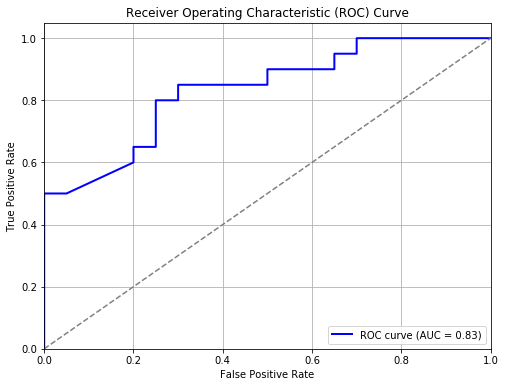

<Figure size 576x432 with 0 Axes>

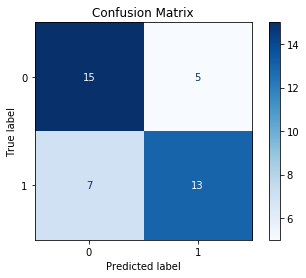

{'model': XGBClassifier(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=0.9999999999999999, device=None,
               early_stopping_rounds=None, enable_categorical=False,
               eval_metric=None, feature_types=None, gamma=0.2, grow_policy=None,
               importance_type=None, interaction_constraints=None,
               learning_rate=0.25, max_bin=None, max_cat_threshold=None,
               max_cat_to_onehot=None, max_delta_step=None, max_depth=7,
               max_leaves=None, min_child_weight=None, missing=nan,
               monotone_constraints=None, multi_strategy=None, n_estimators=100,
               n_jobs=None, num_parallel_tree=None, random_state=None, ...),
 'selected_features': array([ True,  True,  True]),
 'best_params': {'colsample_bytree': 0.9999999999999999,
  'gamma': 0.2,
  'learning_rate': 0.25,
  'max_depth': 7,
  'n_estimators': 100,
  'subsample': 0.9999

In [52]:
# augmented dataset both classes (1000)
xgb_model = train_xgboost_model(X_train_xgb, X_test_xgb, y_train_xgb, y_test_xgb)
xgb_model

In [66]:
# Create datasets
train_dataset_w = CNNDataset(data=X_train_cnn, data_rcc=y_train_cnn, patient_ids=id_train_cnn) 
test_dataset_w = CNNDataset(data=X_test_cnn, data_rcc=y_test_cnn, patient_ids=id_test_cnn)


In [67]:
test_loader_w  = FilteredDataLoader(test_dataset_w, batch_size = 8, shuffle = False)
train_loader_w  = FilteredDataLoader(train_dataset_w, batch_size = 8, shuffle = True)

## Load Model

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SimplifiedCNN3D256(nn.Module):
    def __init__(self):
        super(SimplifiedCNN3D256, self).__init__()
        self.conv1 = nn.Conv3d(1, 16, kernel_size=3, stride=1, padding=1)
        #self.bn1 = nn.BatchNorm3d(16)
        self.conv2 = nn.Conv3d(16, 32, kernel_size=3, stride=1, padding=1)
        #=self.bn2 = nn.BatchNorm3d(32)
        self.pool = nn.MaxPool3d(2, 2)
        self.fc1 = nn.Linear(32 * 16 * 16 * 8, 256)
        self.fc2 = nn.Linear(256, 2)  # Output layer for binary classification
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 32 * 16 * 16 * 8)
        intermediate_output = self.fc1(x)  # Save intermediate output after fc1
        x = F.relu(intermediate_output)
        x = self.dropout(x)
        x = self.fc2(x)
        return x, intermediate_output


In [68]:
import torch
from torch.nn import Linear
from torchvision.models.video import r3d_18

class resnet3d(torch.nn.Module):
    def __init__(self, in_channels=1, num_classes=2):
        super(resnet3d, self).__init__()
        self.r3d = r3d_18(pretrained=True)
        # Modify the input channels of the first layer to match in_channels
        self.r3d.stem[0] = torch.nn.Conv3d(in_channels, 64, kernel_size=(3, 7, 7), stride=(1, 2, 2), padding=(1, 3, 3), bias=False)
        # Replace the fully connected layer for the number of classes
        self.r3d.fc = Linear(512, num_classes)

    def forward(self, x):
        x = self.r3d(x)
        return x


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(101)
in_channels, num_classes = 1,2
model_resnet3d = resnet3d(1,2).to(device)
print(model_resnet3d)

The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=R3D_18_Weights.KINETICS400_V1`. You can also use `weights=R3D_18_Weights.DEFAULT` to get the most up-to-date weights.


resnet3d(
  (r3d): VideoResNet(
    (stem): BasicStem(
      (0): Conv3d(1, 64, kernel_size=(3, 7, 7), stride=(1, 2, 2), padding=(1, 3, 3), bias=False)
      (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Sequential(
          (0): Conv3DSimple(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
          (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (conv2): Sequential(
          (0): Conv3DSimple(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
          (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (relu): ReLU(inplace=True)
      )
      (1): BasicBlock(
        (conv1): Sequential(
          (0): Conv3DSimple(64, 64, kernel_size=(3, 3, 3), 

In [69]:
from sklearn.model_selection import KFold
import torch.nn as nn
from sklearn.metrics import accuracy_score


# Define number of folds
num_folds = 5
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

# Initialize lists to store losses and accuracies across folds
all_train_losses = []
all_val_losses = []
all_train_accuracies = []
all_val_accuracies = []

# Assuming you have already saved augmented data in dictionaries
aug_pos_data = aug_pos_data_dict_['img'][:928]
aug_pos_labels = aug_pos_data_dict_['label'][:928]
aug_pos_ids = aug_pos_data_dict_['Patient_ID'][:928]

aug_neg_data = aug_neg_data_dict_['img']
aug_neg_labels = aug_neg_data_dict_['label']
aug_neg_ids = aug_neg_data_dict_['Patient_ID']

# Loop over the folds
for fold, (train_index, val_index) in enumerate(kf.split(X_train_cnn)):
    print(f"Fold {fold + 1}/{num_folds}")

    # Create training and validation sets for this fold
    X_train_fold = [X_train_cnn[i] for i in train_index]
    y_train_fold = [y_train_cnn[i] for i in train_index]
    id_train_fold = [id_train_cnn[i] for i in train_index]

    X_val_fold = [X_train_cnn[i] for i in val_index]
    y_val_fold = [y_train_cnn[i] for i in val_index]
    id_val_fold = [id_train_cnn[i] for i in val_index]

    # Add augmented positive samples to the training set
    
    X_train_fold.extend(aug_pos_data)
    y_train_fold.extend(aug_pos_labels)
    id_train_fold.extend(aug_pos_ids)

    # Add augmented negative samples to the training set (each sample 3 times)
    
    X_train_fold.extend(aug_neg_data)
    y_train_fold.extend(aug_neg_labels)
    id_train_fold.extend(aug_neg_ids)

    # Create datasets for this fold
    train_fold_dataset = CNNDataset(data=X_train_fold, data_rcc=y_train_fold, patient_ids=id_train_fold)
    val_fold_dataset = CNNDataset(data=X_val_fold, data_rcc=y_val_fold, patient_ids=id_val_fold)

    # Create DataLoaders for this fold
    train_fold_loader = FilteredDataLoader(train_fold_dataset, batch_size=32, shuffle=True)
    val_fold_loader = FilteredDataLoader(val_fold_dataset, batch_size=8, shuffle=True) # I added shuffling

    # Initialize model, optimizer, scheduler, etc.
    attention_model = model_resnet3d
    optimizer = torch.optim.Adam(attention_model.parameters(), lr=0.001)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.5)
    criterion = nn.CrossEntropyLoss()

    # Early stopping
    patience = 5 # modified
    best_loss = float('inf')
    patience_counter = 0

    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    # Training loop for this fold
    for epoch in range(10):
        attention_model.train()
        train_loss = 0.0
        train_correct = 0
        train_labels = []
        train_preds = []

        for train_data in train_fold_loader:
            inputs, labels = train_data['img'].to(device), train_data['label'].to(device)
            optimizer.zero_grad()
            outputs = attention_model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            train_correct += torch.sum(preds == labels.data)
            train_labels.extend(labels.cpu().numpy())
            train_preds.extend(preds.cpu().numpy())

        train_loss = train_loss / len(train_fold_loader.dataset)
        train_accuracy = accuracy_score(train_labels, train_preds)

        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        # Validation loop for this fold
        attention_model.eval()
        val_loss = 0.0
        val_correct = 0
        val_labels = []
        val_preds = []

        with torch.no_grad():
            for val_data in val_fold_loader:
                inputs, labels = val_data['img'].to(device), val_data['label'].to(device)
                outputs = attention_model(inputs)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * inputs.size(0)
                _, preds = torch.max(outputs, 1)
                val_correct += torch.sum(preds == labels.data)
                val_labels.extend(labels.cpu().numpy())
                val_preds.extend(preds.cpu().numpy())

        val_loss = val_loss / len(val_fold_loader.dataset)
        val_accuracy = accuracy_score(val_labels, val_preds)

        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        print(f'Epoch: {epoch+1} \t Training Loss: {train_loss:.5f} \t Training Balanced Accuracy: {train_accuracy:.5f} \t Validation Loss: {val_loss:.5f} \t Validation Balanced Accuracy: {val_accuracy:.5f}')

        scheduler.step(val_loss)

        # Check for early stopping
        if val_loss < best_loss:
            best_loss = val_loss
            patience_counter = 0
            torch.save(attention_model.state_dict(), f'/projects/renal/02_kidney_classification/01_3DCNN/02_subtypes/models/best_model_fold_{fold + 1}_subtype_resnet.pth')
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print("Early stopping triggered")
            break

    # Append losses and accuracies for this fold to lists
    all_train_losses.append(train_losses)
    all_val_losses.append(val_losses)
    all_train_accuracies.append(train_accuracies)
    all_val_accuracies.append(val_accuracies)


Fold 1/5
Epoch: 1 	 Training Loss: 0.72821 	 Training Balanced Accuracy: 0.51688 	 Validation Loss: 0.72003 	 Validation Balanced Accuracy: 0.07500
Epoch: 2 	 Training Loss: 0.70064 	 Training Balanced Accuracy: 0.51186 	 Validation Loss: 0.82752 	 Validation Balanced Accuracy: 0.07500
Epoch: 3 	 Training Loss: 0.70437 	 Training Balanced Accuracy: 0.52190 	 Validation Loss: 1.24188 	 Validation Balanced Accuracy: 0.07500
Epoch: 4 	 Training Loss: 0.69819 	 Training Balanced Accuracy: 0.52235 	 Validation Loss: 0.62863 	 Validation Balanced Accuracy: 0.92500
Epoch: 5 	 Training Loss: 0.70355 	 Training Balanced Accuracy: 0.53650 	 Validation Loss: 0.88716 	 Validation Balanced Accuracy: 0.12500
Epoch: 6 	 Training Loss: 0.70187 	 Training Balanced Accuracy: 0.52646 	 Validation Loss: 0.68591 	 Validation Balanced Accuracy: 0.30000
Epoch: 7 	 Training Loss: 0.70087 	 Training Balanced Accuracy: 0.54334 	 Validation Loss: 0.90283 	 Validation Balanced Accuracy: 0.07500
Epoch: 8 	 Trainin

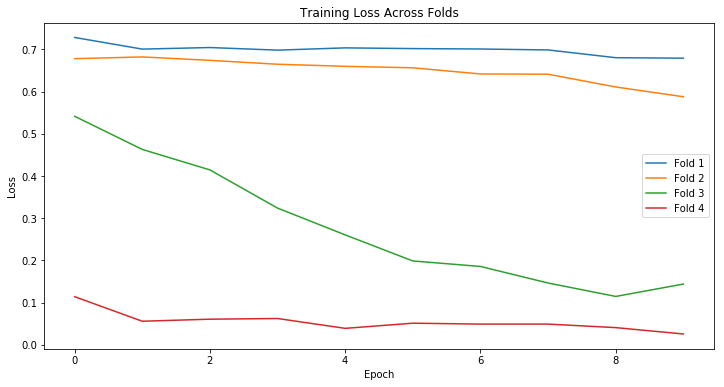

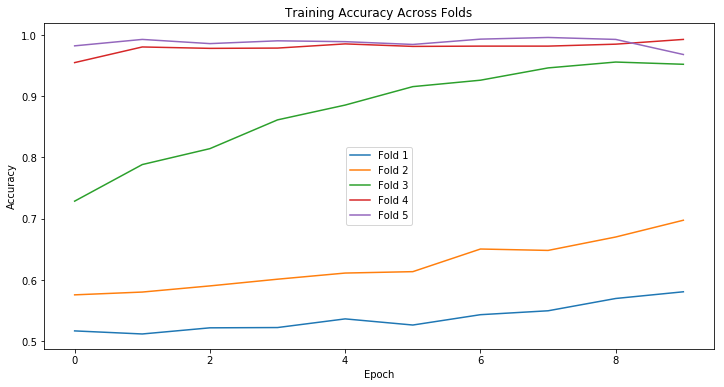

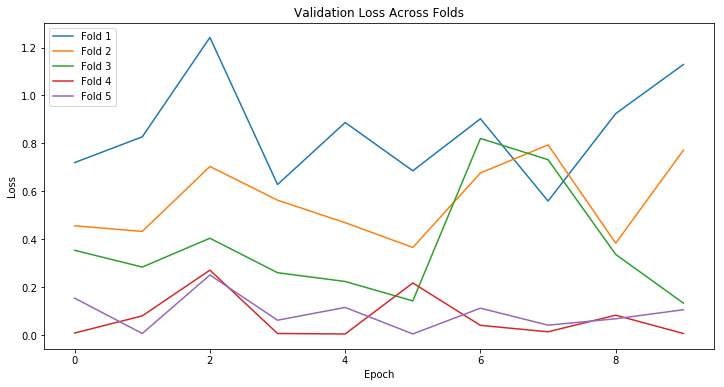

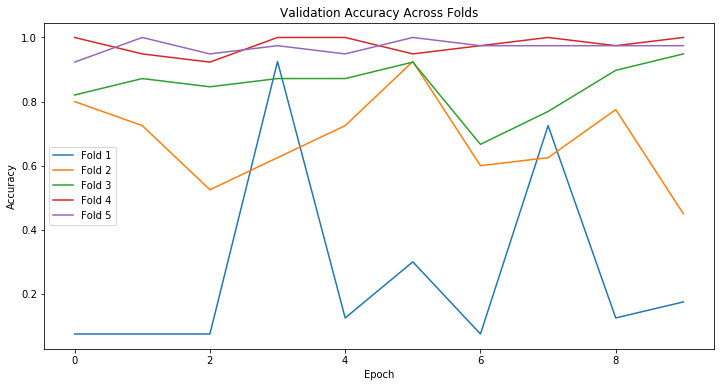

In [70]:
import matplotlib.pyplot as plt

# Plotting train loss for all folds
plt.figure(figsize=(12, 6))
for fold in range(num_folds-1):
    plt.plot(all_train_losses[fold], label=f'Fold {fold+1}')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Across Folds')
plt.legend()
plt.show()

# Plotting train accuracy for all folds
plt.figure(figsize=(12, 6))
for fold in range(num_folds):
    plt.plot(all_train_accuracies[fold], label=f'Fold {fold+1}')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training Accuracy Across Folds')
plt.legend()
plt.show()

# Plotting validation loss for all folds
plt.figure(figsize=(12, 6))
for fold in range(num_folds):
    plt.plot(all_val_losses[fold], label=f'Fold {fold+1}')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Validation Loss Across Folds')
plt.legend()
plt.show()

# Plotting validation accuracy for all folds
plt.figure(figsize=(12, 6))
for fold in range(num_folds):
    plt.plot(all_val_accuracies[fold], label=f'Fold {fold+1}')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy Across Folds')
plt.legend()
plt.show()

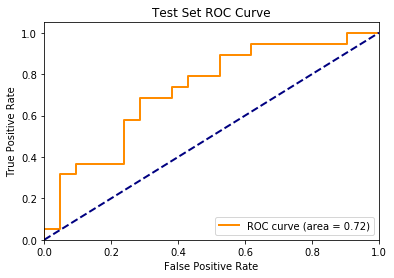

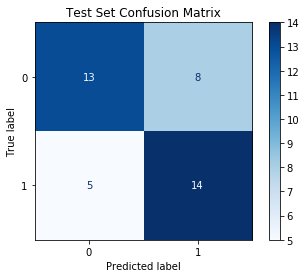

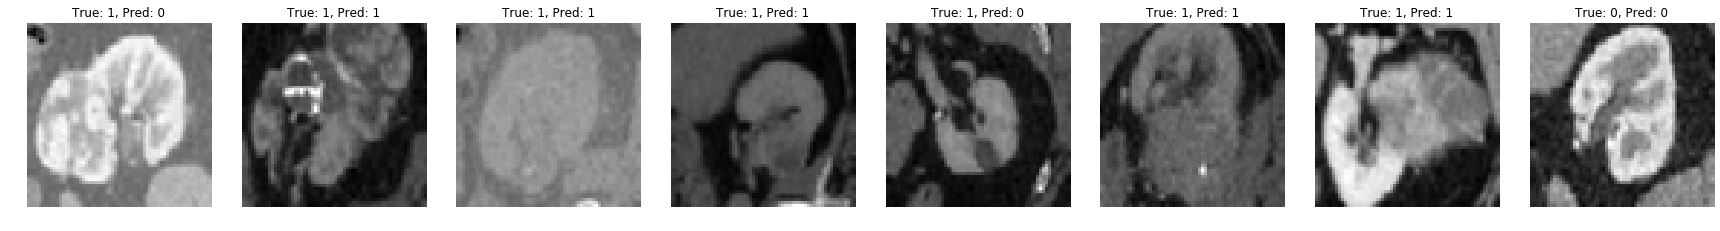

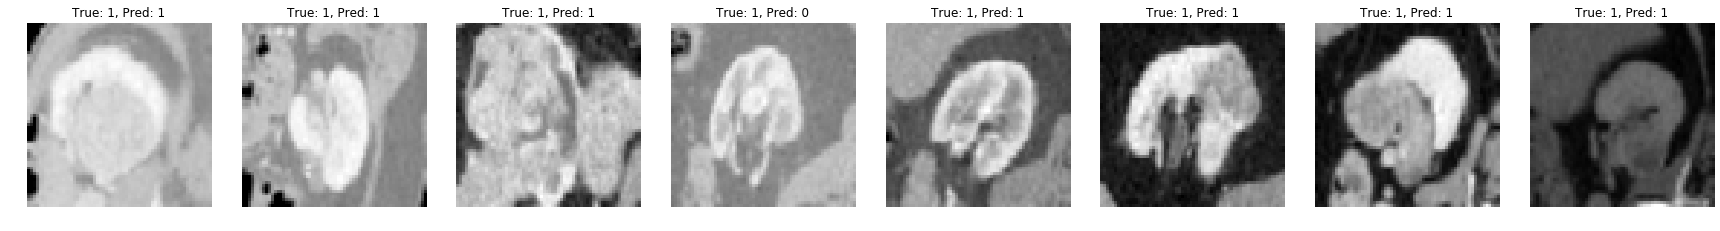

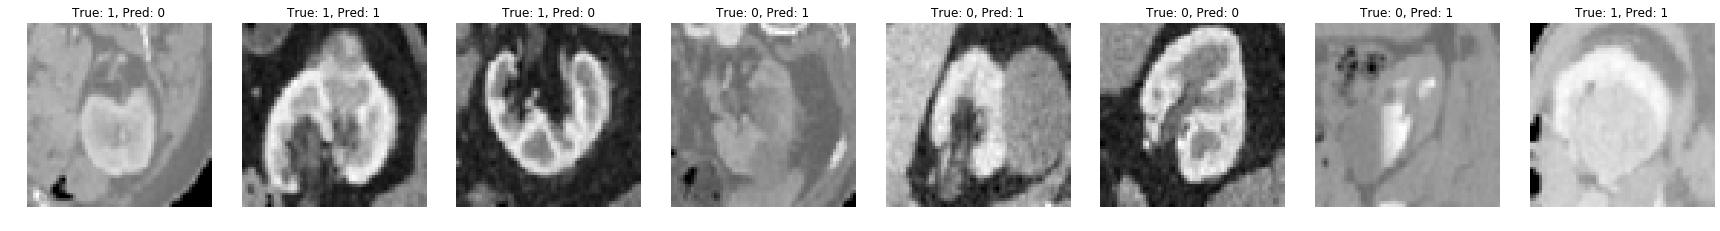

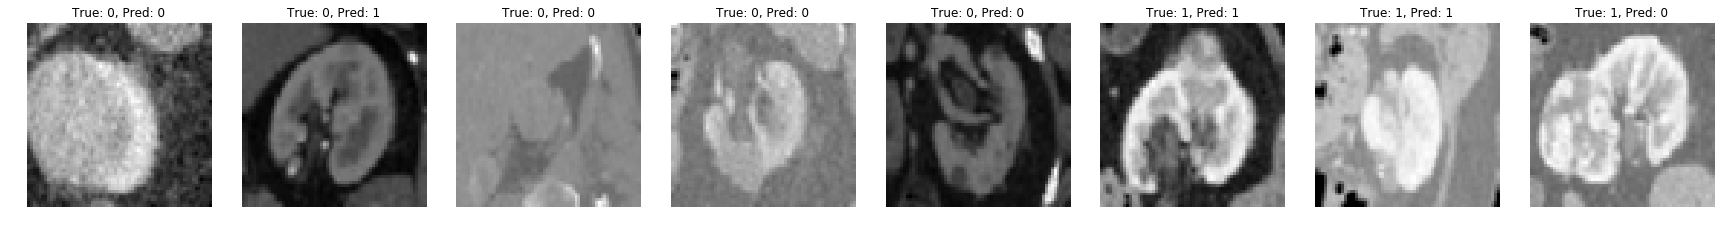

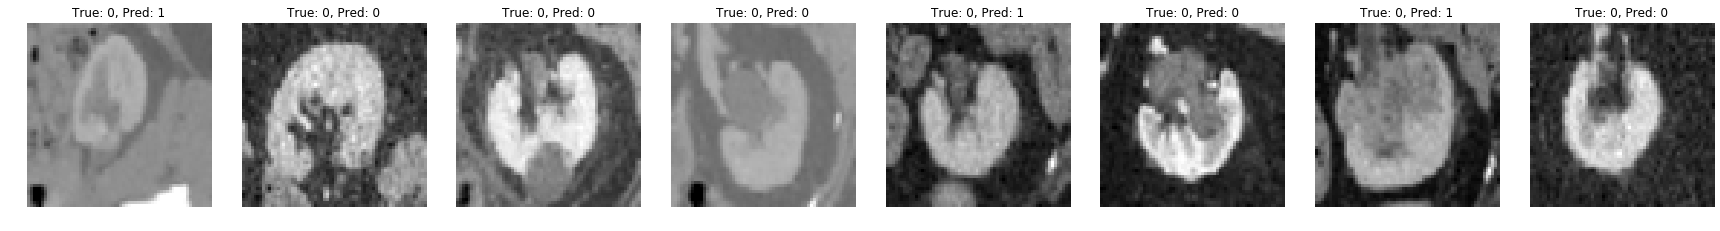

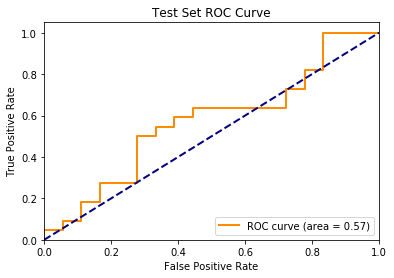

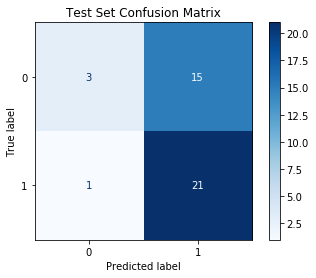

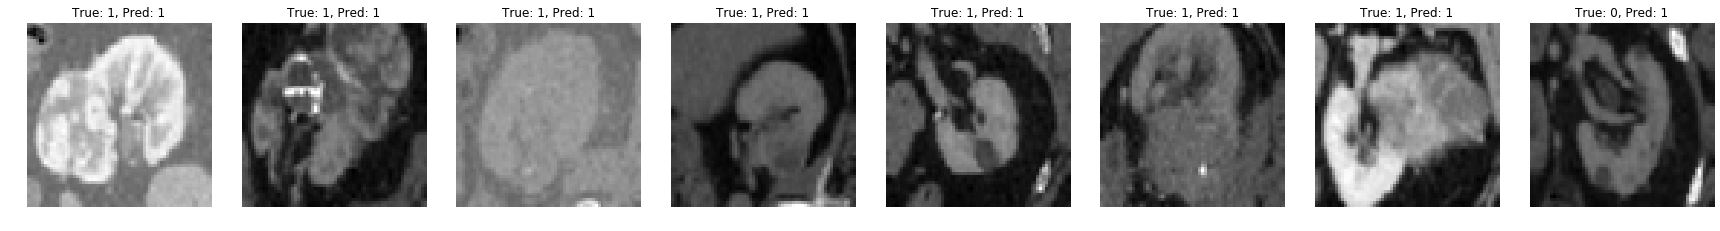

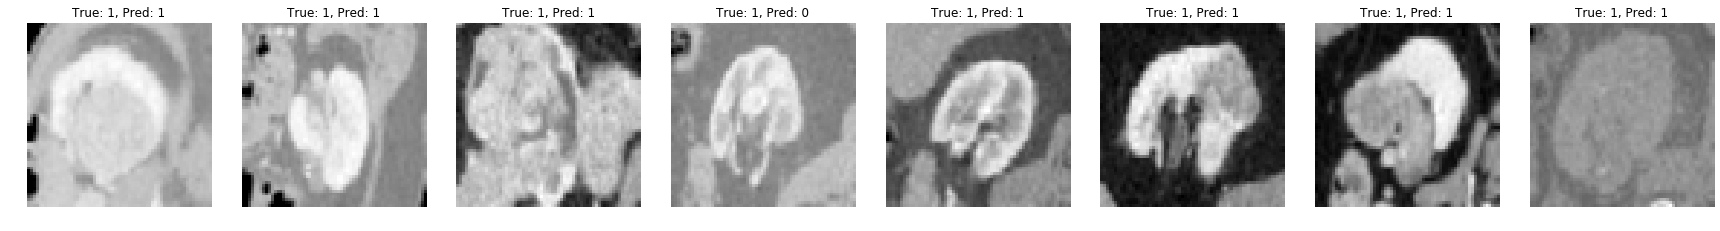

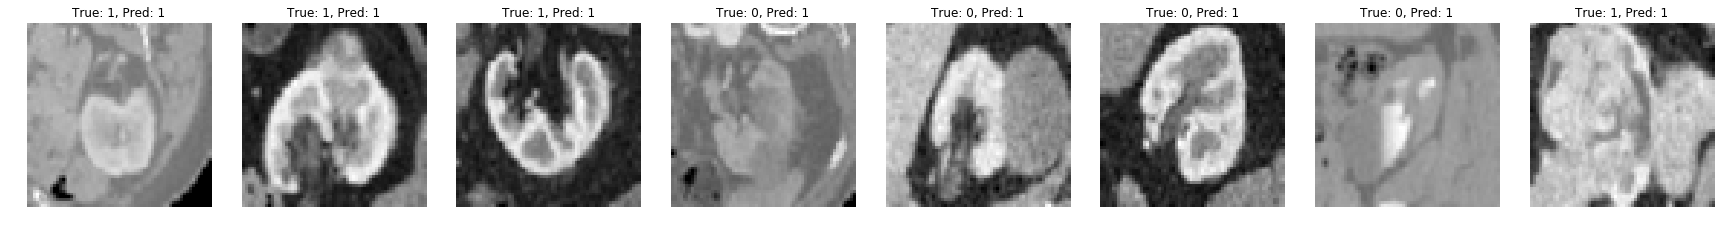

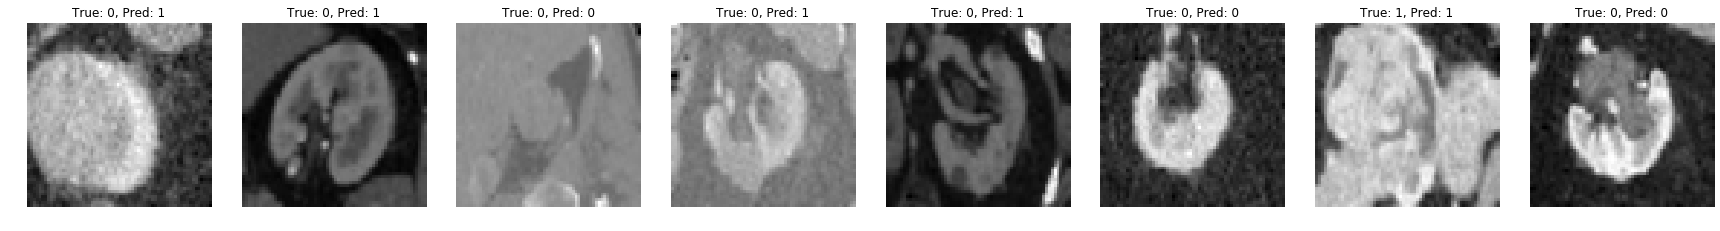

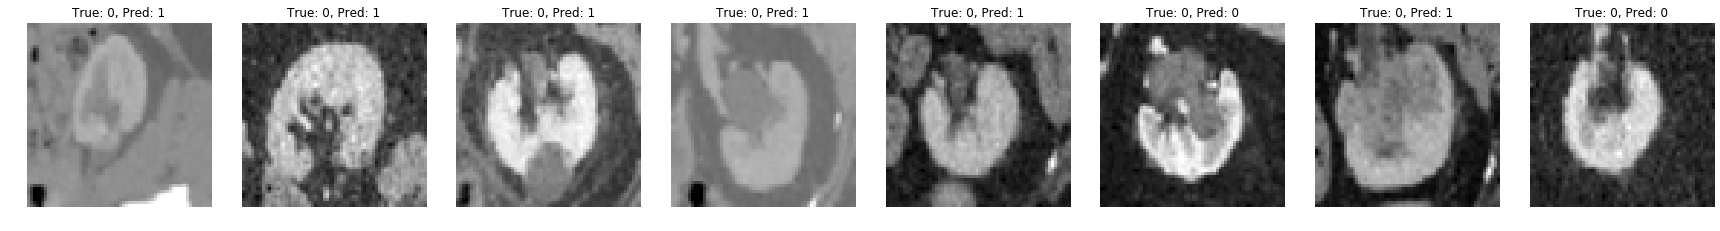

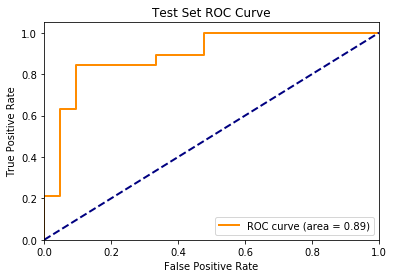

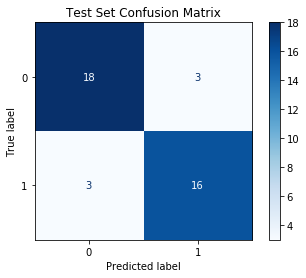

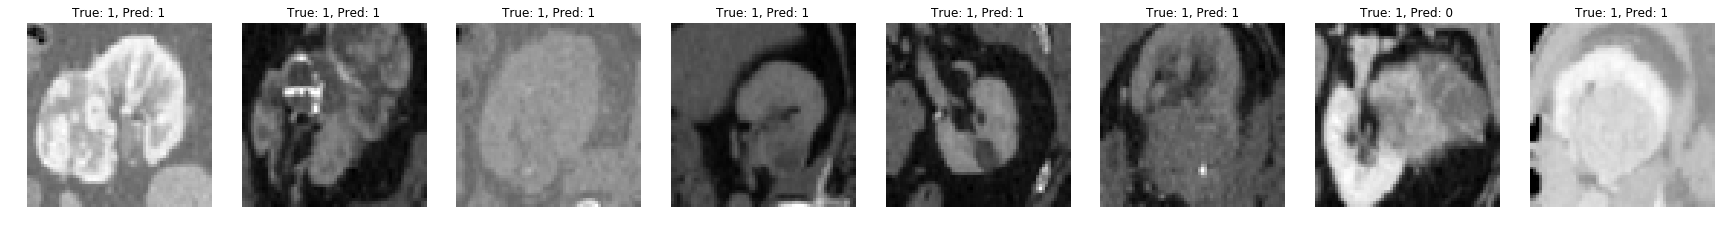

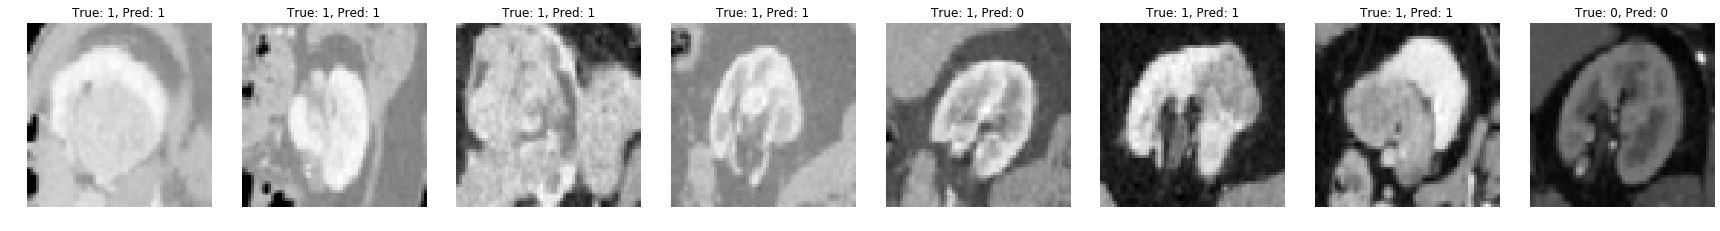

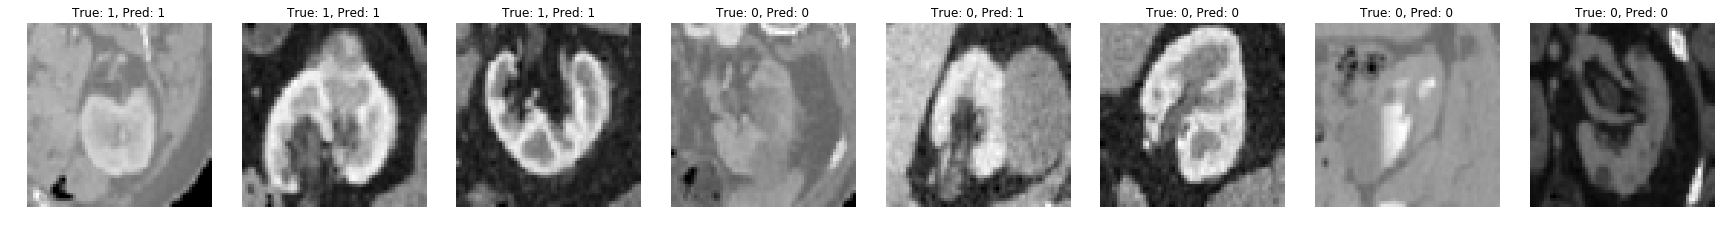

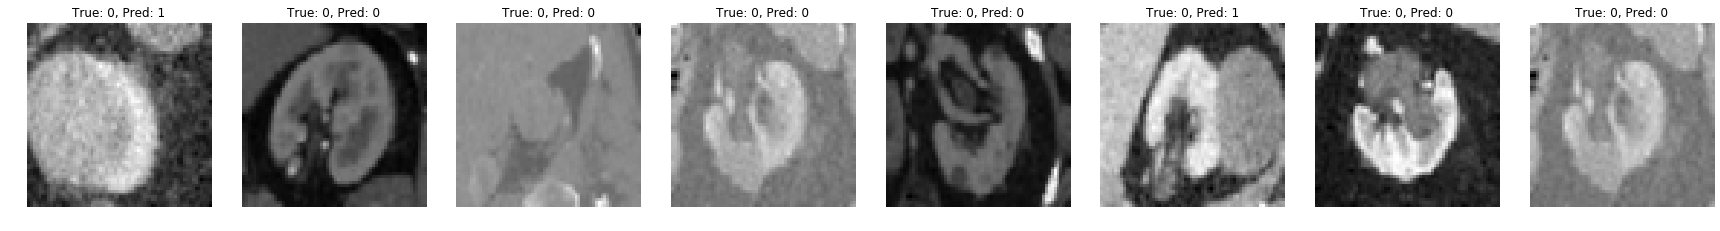

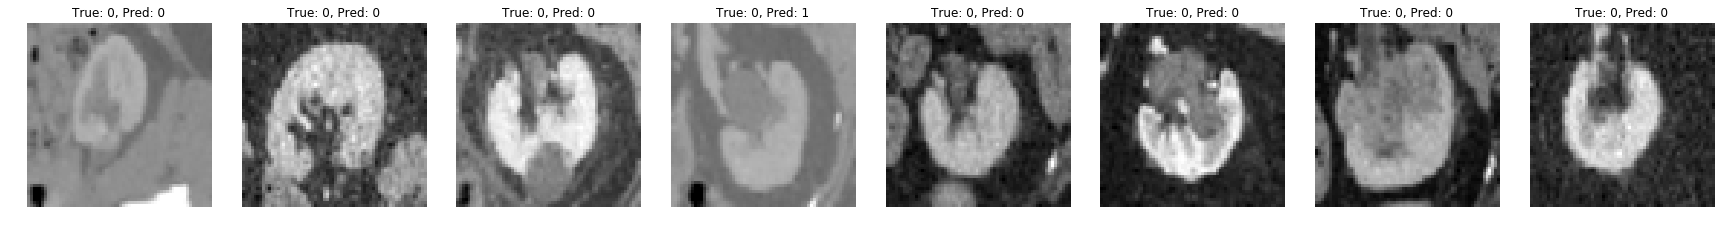

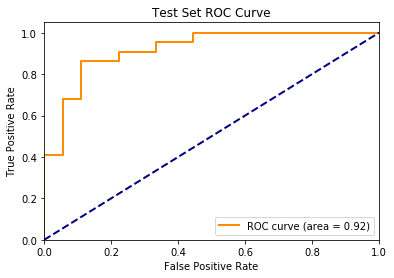

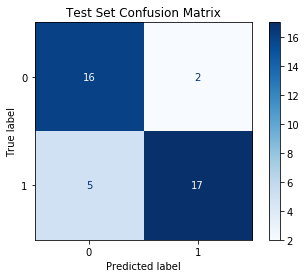

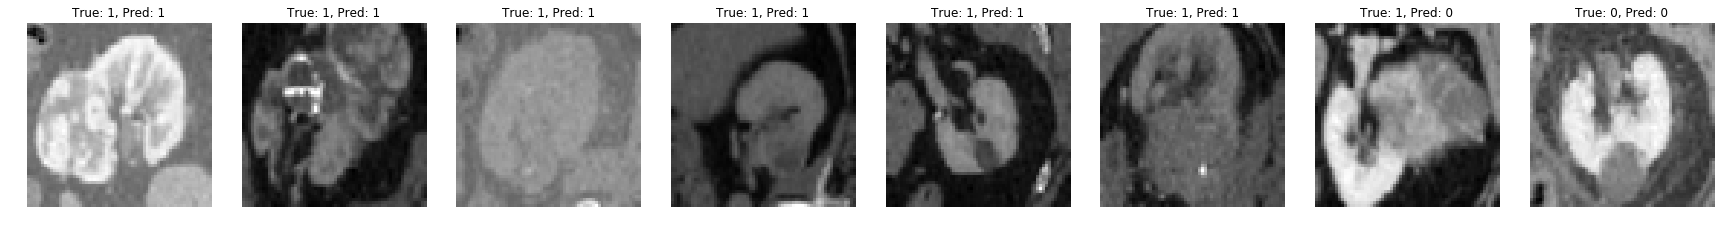

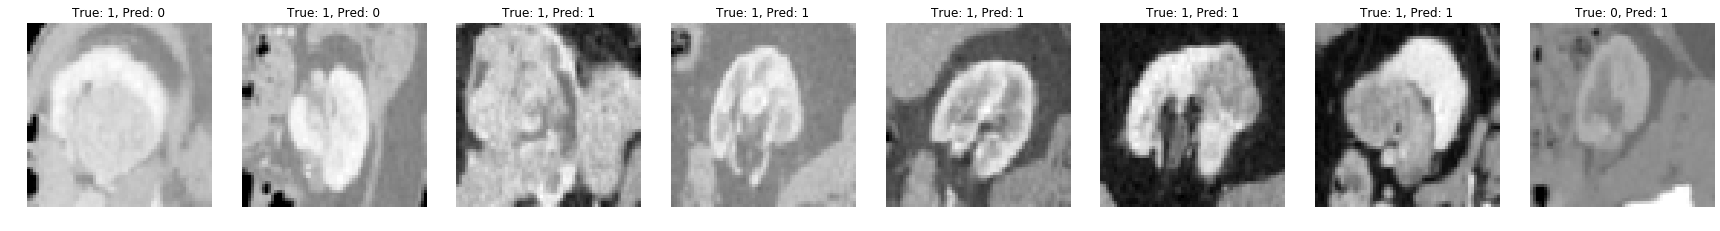

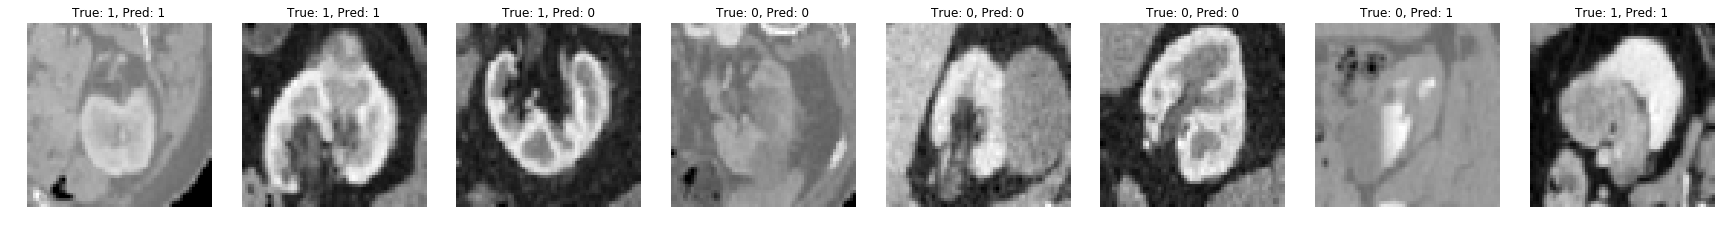

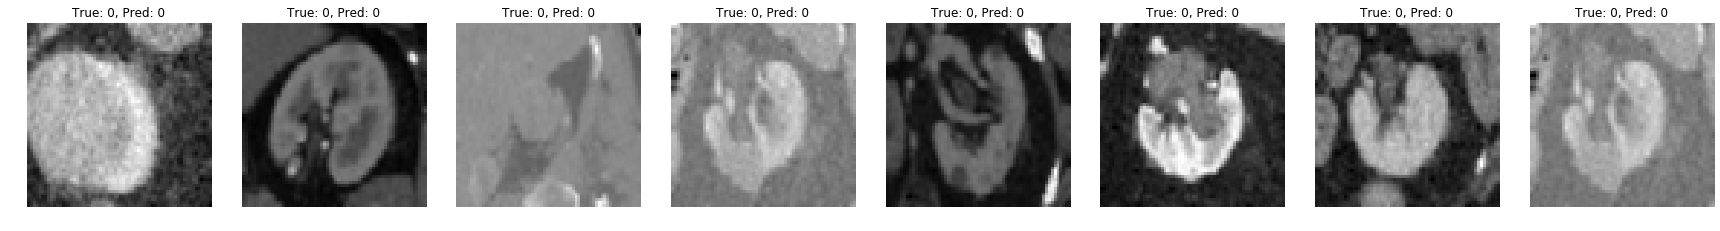

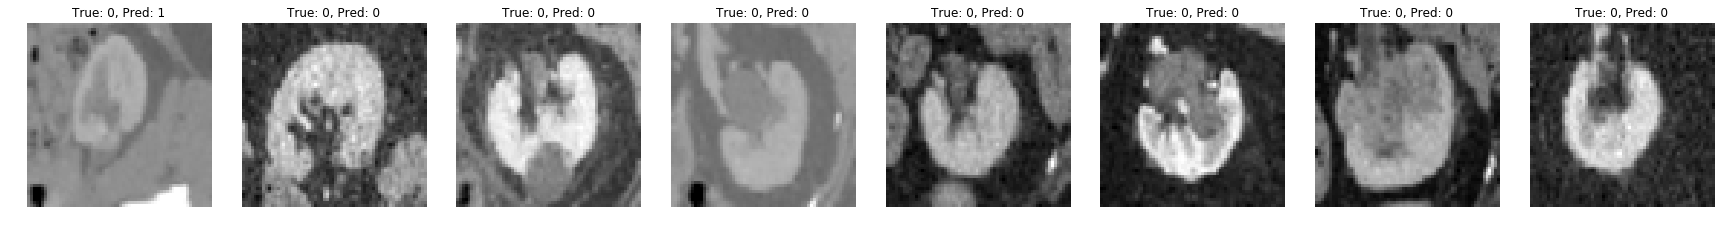

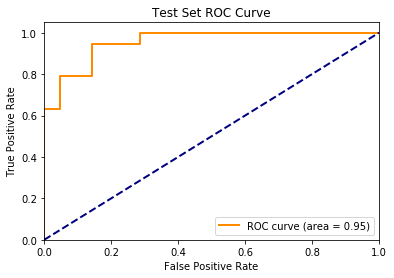

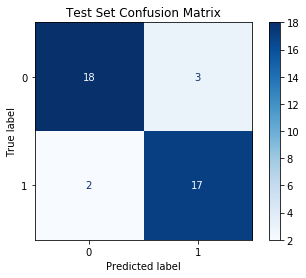

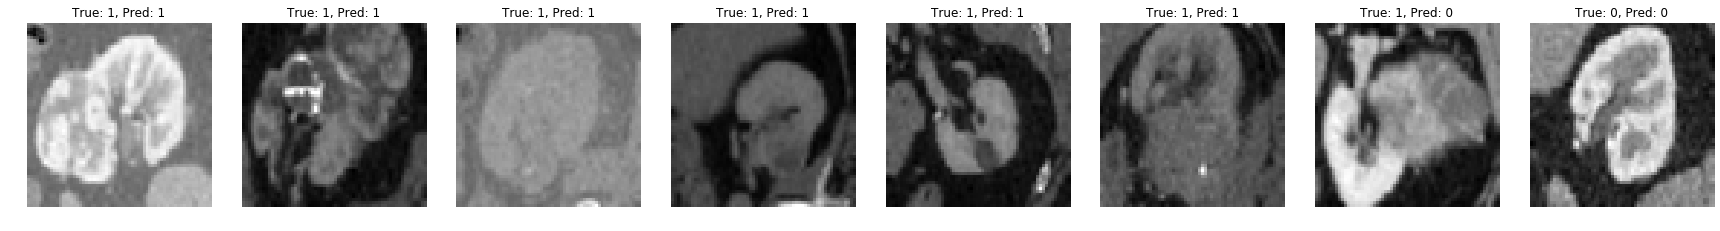

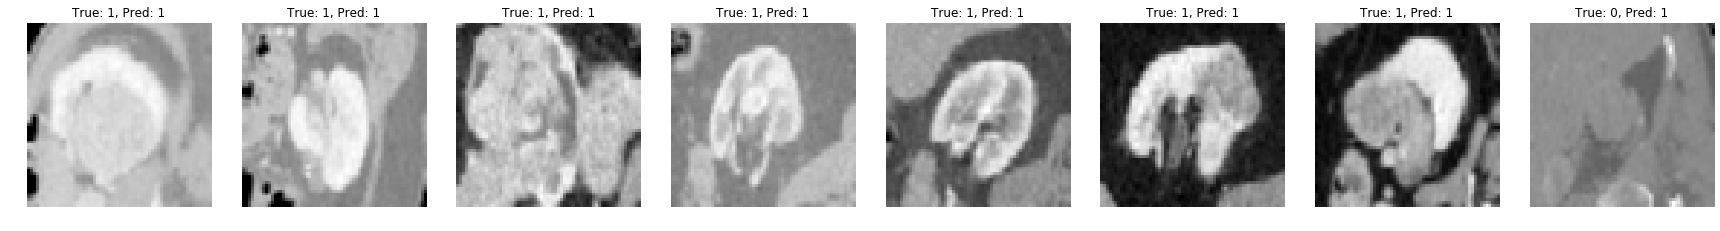

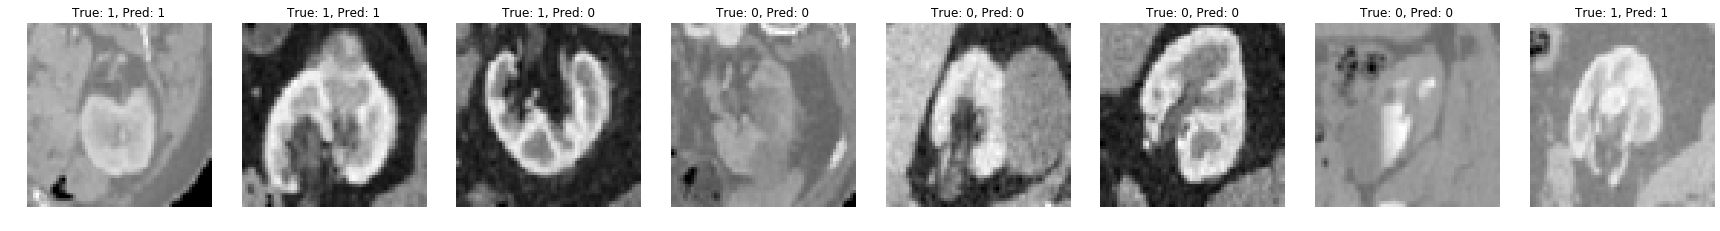

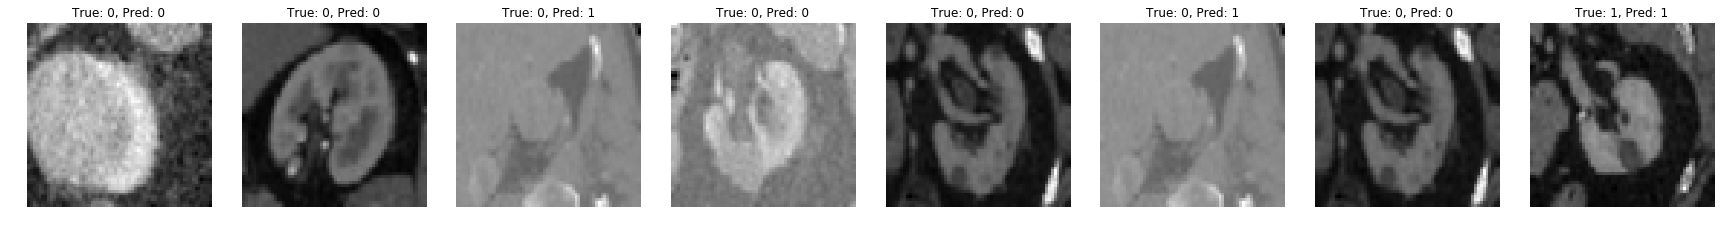

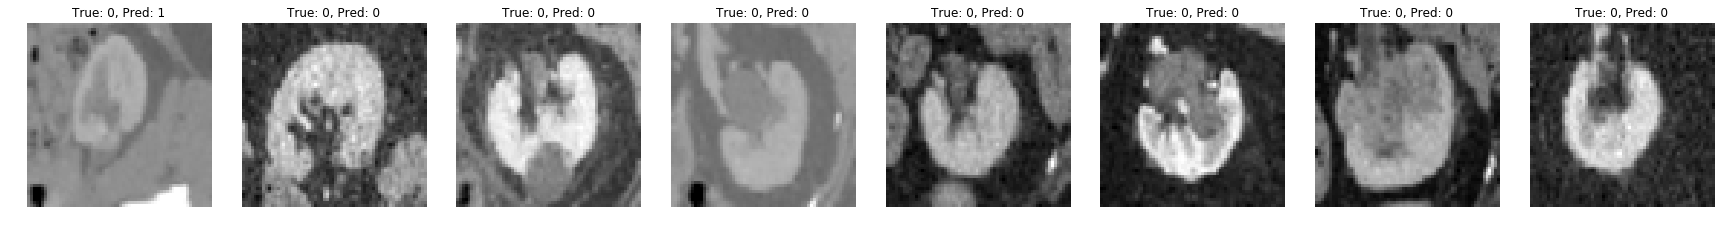

In [72]:
from sklearn.metrics import roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay
import matplotlib.pyplot as plt

def plot_roc_curve(y_true, y_pred_proba, title='ROC Curve'):
    fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:0.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc='lower right')
    plt.show()

def plot_confusion_matrix(y_true, y_pred, title='Confusion Matrix'):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(title)
    plt.show()

def get_predictions(model, data_loader):
    model.eval()
    all_labels = []
    all_probs = []
    all_preds = []

    with torch.no_grad():
        for data in data_loader:
            inputs, labels = data['img'].to(device), data['label'].to(device)
            outputs = model(inputs)
            probs = torch.softmax(outputs, dim=1)[:, 1]  # Get probabilities for the positive class
            preds = torch.argmax(outputs, dim=1)

            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

    return all_labels, all_probs, all_preds

def plot_predictions(data_loader, model):
    model.eval()
    
    with torch.no_grad():
        for i, data in enumerate(data_loader):
            inputs, labels = data['img'].to(device), data['label'].to(device)
            outputs = model(inputs)
            preds = torch.argmax(outputs, dim=1)
            batch_size = inputs.size(0)

            fig, axes = plt.subplots(1, batch_size, figsize=(24, 8))
            for j in range(batch_size):
                ax = axes[j]
                img = inputs[j][0, :, :, 15].cpu().numpy()  # Adjust according to your image shape
                ax.imshow(img, cmap='gray')
                ax.set_title(f"True: {labels[j].cpu().numpy()}, Pred: {preds[j].cpu().numpy()}")
                ax.axis('off')
                
            plt.tight_layout()
            plt.show()

for fold in range(5):
    # Assuming your best model is loaded
    attention_model.load_state_dict(torch.load(f'/projects/renal/02_kidney_classification/01_3DCNN/02_subtypes/models/best_model_fold_{fold + 1}_subtype_resnet.pth'))

    test_labels, test_probs, test_preds = get_predictions(attention_model, test_loader_w)
    # Plot ROC Curves
    plot_roc_curve(test_labels, test_probs, title='Test Set ROC Curve')

    # Plot Confusion Matrices
    plot_confusion_matrix(test_labels, test_preds, title='Test Set Confusion Matrix')

    plot_predictions(test_loader_w, attention_model)



In [9]:
# Instantiate the simplified model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(101)
rcc_vs_nonrcc_clf = SimplifiedCNN3D256().to(device)
grade_clf = SimplifiedCNN3D256().to(device)
pap_vs_nonpap_clf = SimplifiedCNN3D256().to(device)


In [10]:
rcc_vs_nonrcc_clf.load_state_dict(torch.load('/projects/renal/02_kidney_classification/01_3DCNN/00_ccRCC_vs_Non_ccRCC/best_model_fold_3_full_aug_corrected.pth'))

<All keys matched successfully>

## Classifications

In [57]:
from sklearn.metrics import roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay
import matplotlib.pyplot as plt

def plot_roc_curve(y_true, y_pred_proba, title='ROC Curve'):
    fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:0.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc='lower right')
    plt.show()

def plot_confusion_matrix(y_true, y_pred, title='Confusion Matrix'):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(title)
    plt.show()

def get_predictions(model, data_loader):
    #model.eval()
    all_labels = []
    all_probs = []
    all_preds = []

    with torch.no_grad():
        for data in data_loader:
            inputs, labels = data['img'].to(device), data['label'].to(device)
            outputs, _ = model(inputs)
            probs = torch.softmax(outputs, dim=1)[:, 1]  # Get probabilities for the positive class
            preds = torch.argmax(outputs, dim=1)

            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

    return all_labels, all_probs, all_preds

def plot_predictions(data_loader, model, model_name):
    #model.eval()
    
    with torch.no_grad():
        for i, data in enumerate(data_loader):
            inputs, labels = data['img'].to(device), data['label'].to(device)
            outputs, _ = model(inputs)
            preds = torch.argmax(outputs, dim=1)
            batch_size = inputs.size(0)
            patients = data["Patient_ID"]

            fig, axes = plt.subplots(1, batch_size, figsize=(24, 8))
            for j in range(batch_size):
                ax = axes[j]
                patient = patients[j]
                img = inputs[j][0, :, :, 15].cpu().numpy()  # Adjust according to your image shape
                ax.imshow(img, cmap='gray')
                if model_name == 'rcc_vs_nonrcc_clf':
                    if labels[j].cpu().numpy() == 0:
                        true = 'Non ccRCC'
                    else:
                        true = 'ccRCC'
                    if preds[j].cpu().numpy() == 0:
                        out = 'Non ccRCC'
                    else:
                        out = 'ccRCC'
                if model_name == 'pap_vs_nonpap_clf':
                    if labels[j].cpu().numpy() == 0:
                        true = 'Pap ccRCC'
                    else:
                        true = 'ccRCC'
                    if preds[j].cpu().numpy() == 0:
                        out = 'Pap ccRCC'
                    else:
                        out = 'ccRCC'

                if model_name == 'grade_clf':
                    if labels[j].cpu().numpy() == 0:
                        true = 0
                    else:
                        true = 1
                    if preds[j].cpu().numpy() == 0:
                        out = 0
                    else:
                        out = 1

                ax.set_title(f"True: {true}, Pred: {out}")
                #ax.set_title(patient)
                ax.axis('off')
                
            plt.tight_layout()
            plt.show()

In [20]:
for i, data in enumerate(test_loader_w):
            patients = data["Patient_ID"]
            print(patients)


['Renal-CHUS-0131', 'Renal-CHUS-0335', 'Renal-CHUS-0005', 'Renal-CHUS-0446', 'Renal-CHUS-0409', 'Renal-CHUS-0462', 'Renal-CHUS-0349', ['Renal-CHUS-0284']]
['Renal-CHUS-0115', 'Renal-CHUS-0086', 'Renal-CHUS-0050', 'Renal-CHUS-0183', 'Renal-CHUS-0107', 'Renal-CHUS-0208', 'Renal-CHUS-0428', ['Renal-CHUS-0349']]
['Renal-CHUS-0256', 'Renal-CHUS-0287', 'Renal-CHUS-0194', 'Renal-CHUS-0284', 'Renal-CHUS-0006', 'Renal-CHUS-0008', 'Renal-CHUS-0012', 'Renal-CHUS-0020']
['Renal-CHUS-0036', 'Renal-CHUS-0068', 'Renal-CHUS-0069', 'Renal-CHUS-0075', 'Renal-CHUS-0087', ['Renal-CHUS-0107'], ['Renal-CHUS-0428'], ['Renal-CHUS-0075']]
['Renal-CHUS-0125', 'Renal-CHUS-0126', 'Renal-CHUS-0140', 'Renal-CHUS-0141', 'Renal-CHUS-0143', 'Renal-CHUS-0157', 'Renal-CHUS-0159', 'Renal-CHUS-0169']


### 1. ccRCC vs Non ccRCC

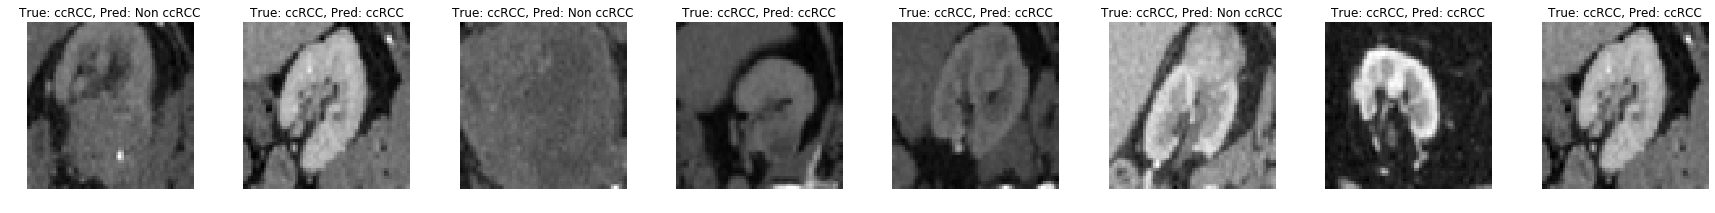

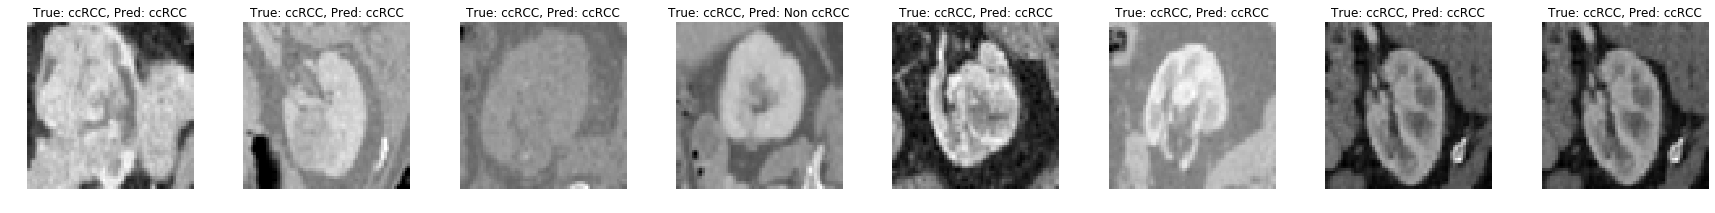

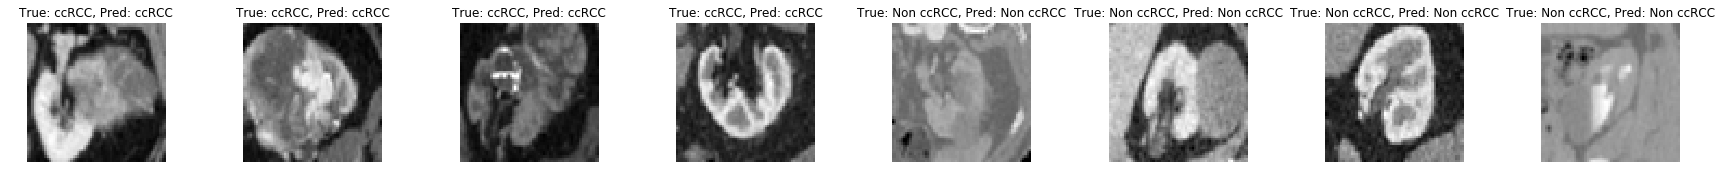

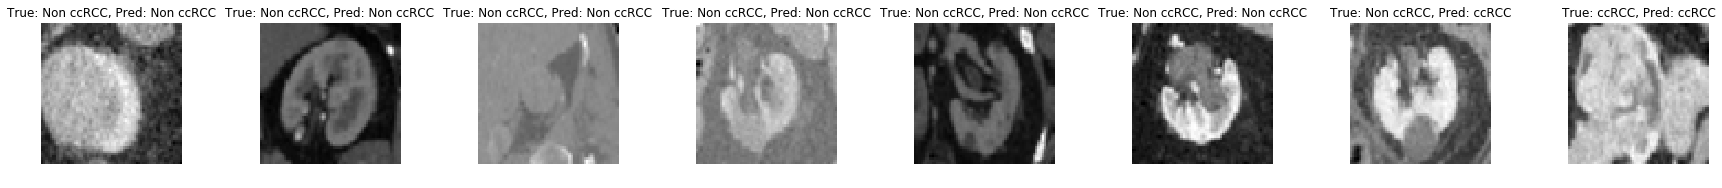

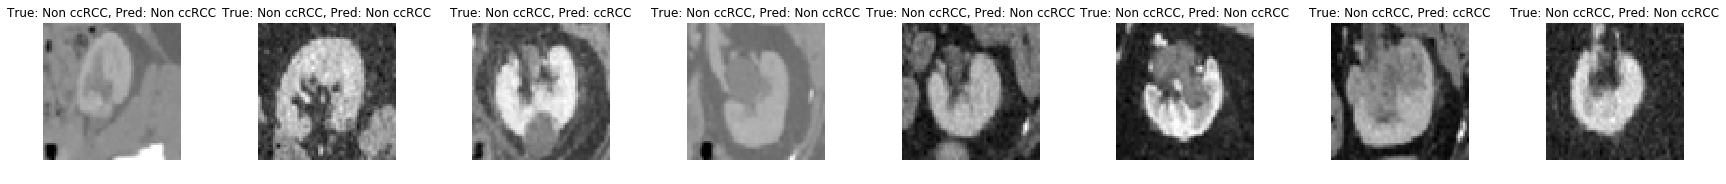

In [25]:
test_labels, test_probs, test_preds = get_predictions(rcc_vs_nonrcc_clf, test_loader_w)
plot_predictions(test_loader_w, rcc_vs_nonrcc_clf, 'rcc_vs_nonrcc_clf')


### 2. Grade

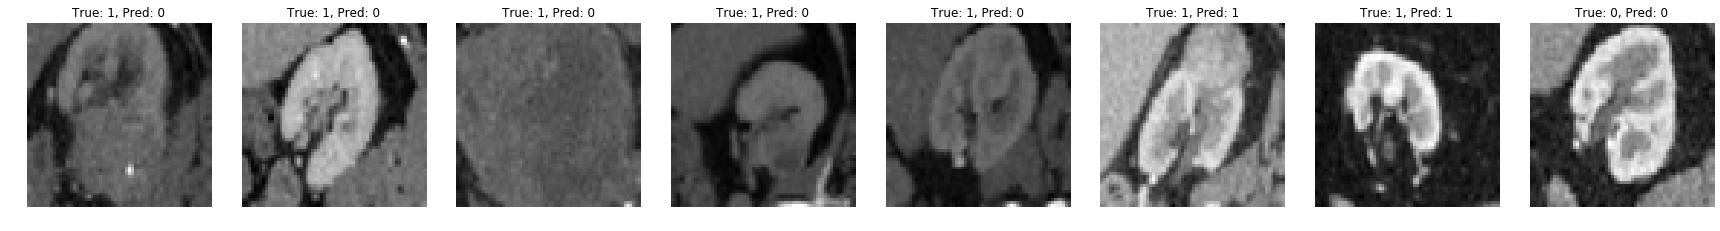

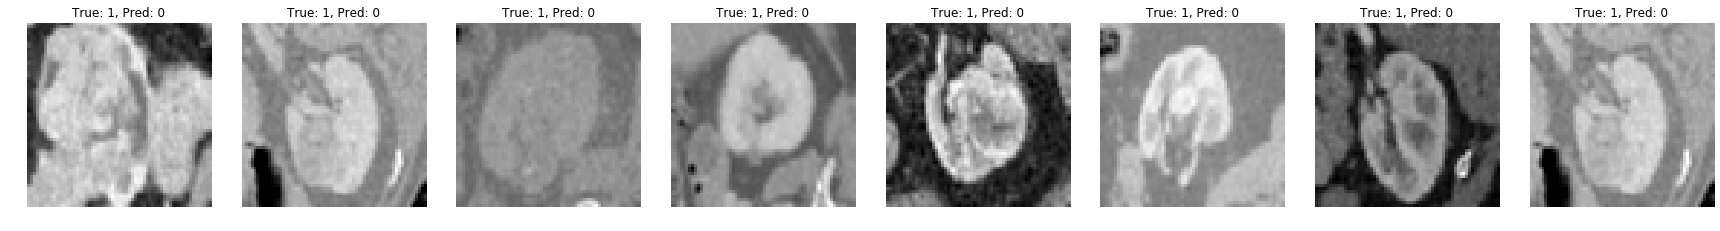

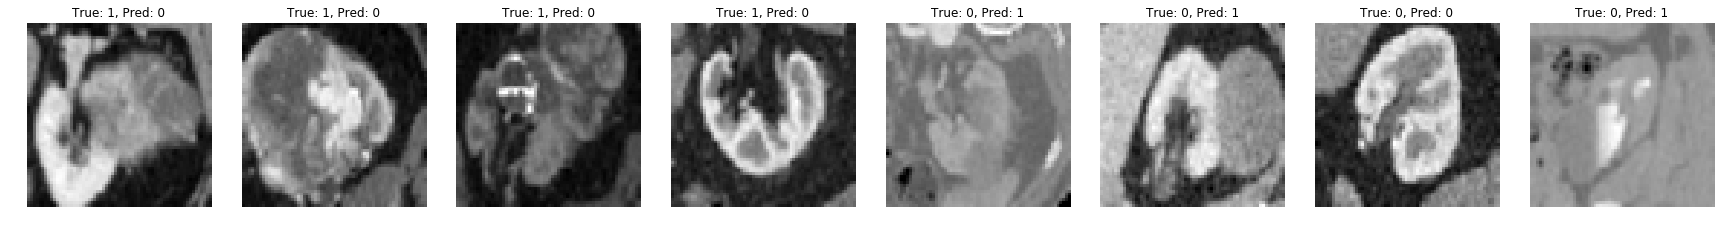

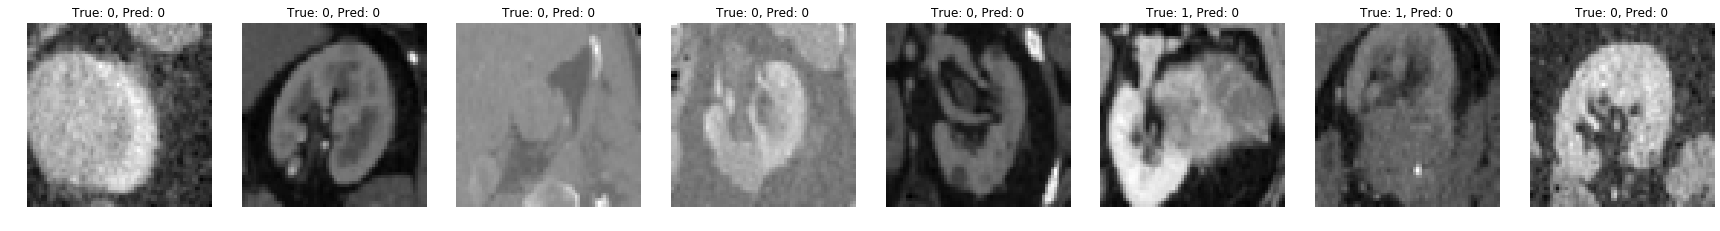

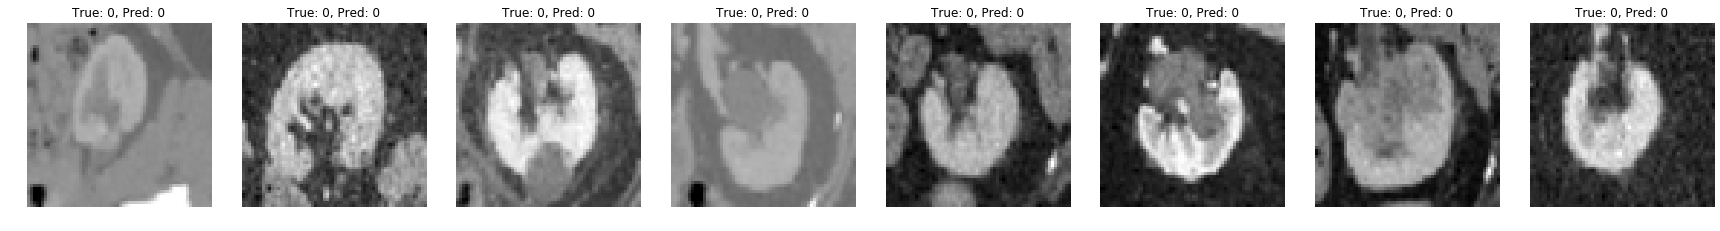

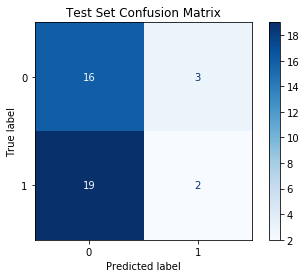

In [34]:
grade_clf.load_state_dict(torch.load('/projects/renal/02_kidney_classification/01_3DCNN/01_grade/models/without_bn/best_model_fold_5_grade_corrected.pth'))

test_labels, test_probs, test_preds = get_predictions(grade_clf, test_loader_w)
plot_predictions(test_loader_w, grade_clf, 'grade_clf')
plot_confusion_matrix(test_labels, test_preds, title='Test Set Confusion Matrix')


### 3. Subtypes

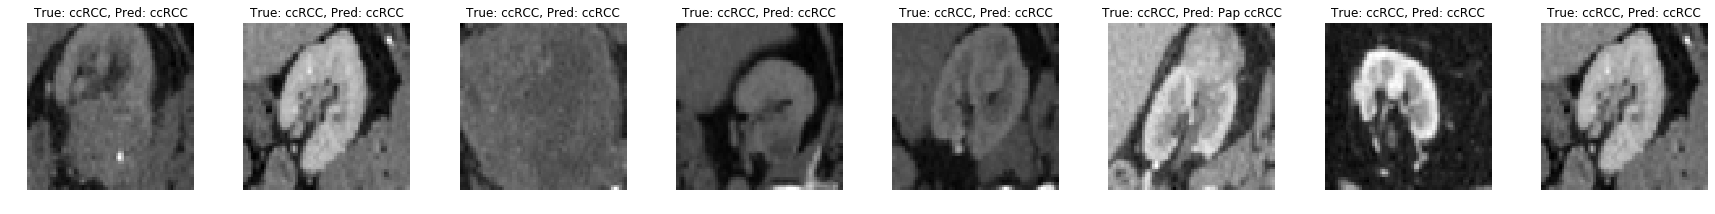

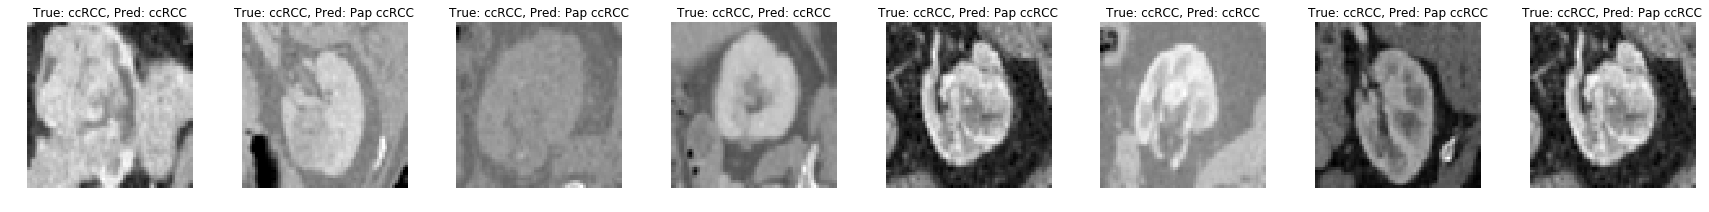

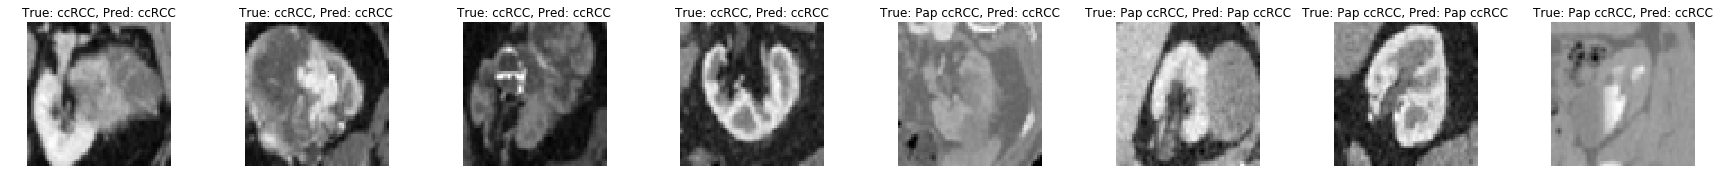

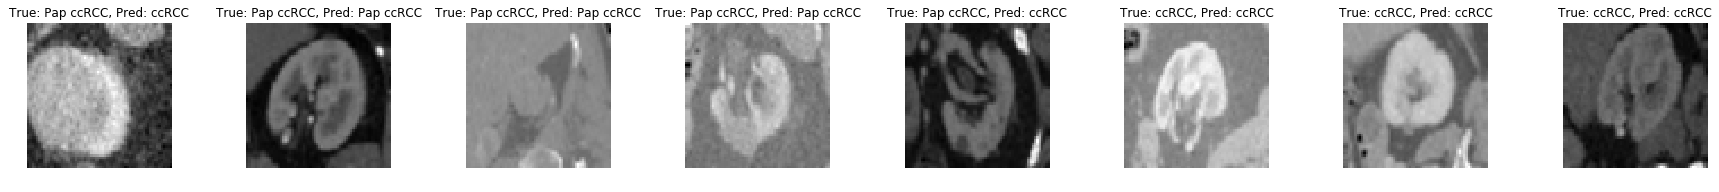

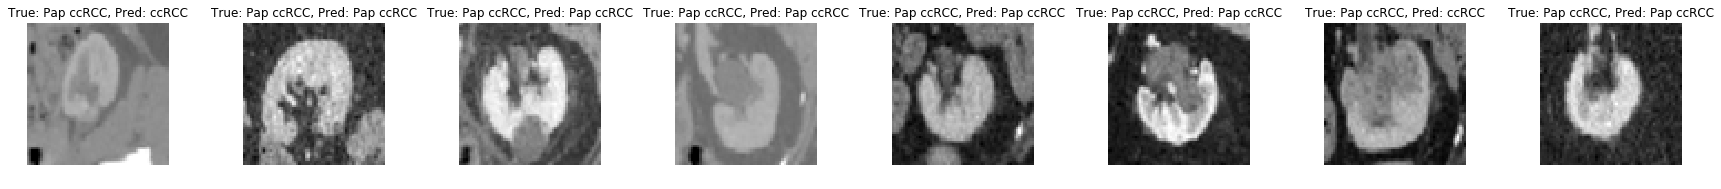

In [35]:
pap_vs_nonpap_clf.load_state_dict(torch.load('/projects/renal/02_kidney_classification/01_3DCNN/02_subtypes/models/best_model_fold_5_subtype.pth'))
test_labels, test_probs, test_preds = get_predictions(pap_vs_nonpap_clf, test_loader_w)
plot_predictions(test_loader_w, pap_vs_nonpap_clf, 'pap_vs_nonpap_clf')